In [1]:
import tensorflow as tf
import numpy as np
from tensorflow_vgg.utils import load_image, print_prob

def rand_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

In [2]:
from tensorflow_vgg.vgg19style import Vgg19

In [18]:
image_size = 512
image = rand_variable([1, image_size, image_size, 3])
# vgg = Vgg16(avg_pooling=True)
vgg = Vgg19('../data/vgg19.npy', avg_pooling=False)
with tf.name_scope('content_vgg'):
    vgg.build(image)

npy file loaded
build model started
build model finished: 0s


In [4]:
session = tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.7))))

In [47]:
# style transfer:
# starrynight.jpg
# lampbear.jpg
# mickey.jpg
# monalisa.jpg
# nate.jpg
# arthur.png

style_image = load_image('../data/arthur.png', size=image_size).reshape((1,image_size,image_size,3))
content_image = load_image('../data/lampbear.jpg', size=image_size).reshape((1,image_size,image_size,3))

In [48]:
content_layer = vgg.conv4_3
style_layers = [vgg.conv1_1, vgg.conv2_2, vgg.conv3_2] # vgg.conv3_3]

In [49]:
# get content layer activations:
session.run(image.assign(content_image))
content_layer_activations = session.run(content_layer)

In [50]:
# get style layer activations:
session.run(image.assign(style_image))

def style_gram(layer):
    _, height, width, channels = [d.value for d in layer.get_shape()]
    features = tf.reshape(layer, [-1, channels])
    gram = tf.matmul(tf.transpose(features), features) / (width * height * channels)
    return gram

style_grams = session.run([style_gram(layer) for layer in style_layers])

In [54]:
CONTENT_WEIGHT = 5
STYLE_WEIGHT = 200
DENOISING_WEIGHT = 200

content_loss = 2 * tf.nn.l2_loss(content_layer - tf.constant(content_layer_activations)) / content_layer_activations.size
style_loss = tf.add_n([2 * tf.nn.l2_loss(target_gram - style_gram(layer)) / target_gram.size for layer, target_gram in zip(style_layers, style_grams)])

# total variational denoising
tv_x = tf.nn.l2_loss(image[:,1:,:,:] - image[:,:image_size-1,:,:])
tv_y = tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:image_size-1,:])
tv_loss = 2 * (tv_x + tv_y)

loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss # + DENOISING_WEIGHT * tv_loss


In [55]:
# we need to initialize the adamoptimizer 
learning_rate = tf.placeholder(tf.float32, shape=[])
stylize_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# stylize_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss) # doesn't work well, very small noisy colored patches


Step: 0; loss: 15934845.0
Step: 10; loss: 6003435.5
Step: 20; loss: 2609592.75
Step: 30; loss: 1586999.25
Step: 40; loss: 1142171.5
Step: 50; loss: 911243.125
Step: 60; loss: 778193.25
Step: 70; loss: 696715.25
Step: 80; loss: 645392.75
Step: 90; loss: 609970.5625


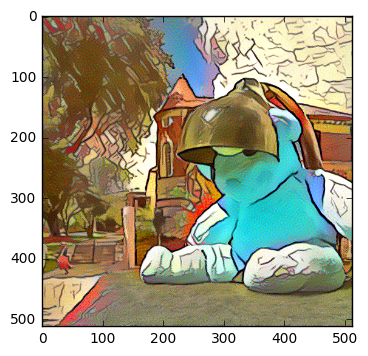

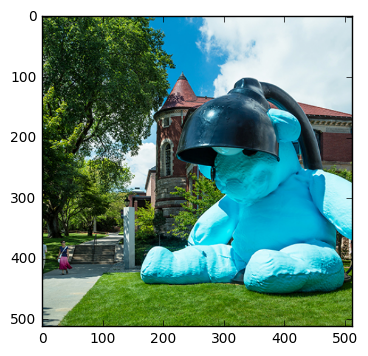

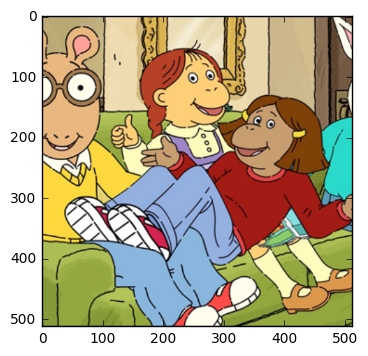

In [56]:
%matplotlib inline

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
init_using_original = True
if init_using_original:
    session.run(image.assign(content_image)) # should we start with random noise instead?
else:
    initial_img = np.abs(np.random.normal(size=[1,image_size,image_size,3], scale=np.std(content_image) * 0.2))
    session.run(image.assign(initial_img)) # init with random noise

lbfgs = False
if lbfgs:
    stylize_op = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': 200}).minimize(session)
else:
    for step in xrange(100):
        lr = 0.1
        if step > 50:
            lr = 0.1
        # if step > 200:
        #    lr = 0.001
        _, loss_ = session.run([stylize_op, loss], feed_dict={learning_rate: lr})
        if step % 10 == 0:
            print 'Step: {}; loss: {}'.format(step, loss_)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow((session.run(image).reshape((image_size,image_size,3))).clip(0,1))
plt.figure()
plt.imshow(content_image.reshape(image_size,image_size,3))
plt.figure()
plt.imshow(style_image.reshape(image_size,image_size,3))